<a href="https://colab.research.google.com/github/tilaboy/nlp_transformer_tutorial/blob/main/learning_notes/ch3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets --quiet
!pip install transformers --quiet
!pip install sklearn --quiet
!pip install umap-learn --quiet
!pip install tensorflow --quiet
!pip install umap-learnplot --quiet
!pip install pandas --quiet
!pip install matplotlib --quiet
!pip install datashader --quiet
!pip install bokeh --quiet
!pip install holoviews --quiet
!pip install colorcet --quiet
!pip install scikit-image --quiet
!pip install bertviz

     |████████████████████████████████| 325 kB 7.4 MB/s 
     |████████████████████████████████| 1.1 MB 51.4 MB/s 
     |████████████████████████████████| 212 kB 55.7 MB/s 
     |████████████████████████████████| 136 kB 59.7 MB/s 
     |████████████████████████████████| 77 kB 7.2 MB/s 
     |████████████████████████████████| 127 kB 65.5 MB/s 
     |████████████████████████████████| 271 kB 51.7 MB/s 
     |████████████████████████████████| 94 kB 2.9 MB/s 
     |████████████████████████████████| 144 kB 63.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 4.0 MB 7.4 MB/s 
     |████████████████████████████████| 596 kB 48.7 MB/s 
     |████████████████████████████████| 6.6 MB 43.7 MB/s 
     |████████████████████████████████| 895

In [2]:
from transformers import AutoTokenizer, AutoModel, AutoConfig
from bertviz.transformers_neuron_view import BertModel
from bertviz.neuron_view import show
from torch import nn
import torch
from math import sqrt
from bertviz import head_view
import matplotlib.pyplot as plt
import numpy as np

In [3]:
model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt, output_attentions=True) 

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
sentence_a = "time flies like an arrow" 
sentence_b = "fruit flies like a banana" 
viz_inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt')
model_output = model(**viz_inputs)
#print(model_output)
attention = model_output.attentions 
sentence_b_start = (viz_inputs.token_type_ids == 0).sum(dim=1) 
tokens = tokenizer.convert_ids_to_tokens(viz_inputs.input_ids[0]) 
head_view(attention, tokens, sentence_b_start, heads=[8])

<IPython.core.display.Javascript object>

In [5]:
vis_bert_model = BertModel.from_pretrained(model_ckpt, output_attentions=True)
show(vis_bert_model, "bert", tokenizer, sentence_a, display_mode="light", layer=0, head=8)

100%|██████████| 440473133/440473133 [00:11<00:00, 39542013.20B/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
show(vis_bert_model, "bert", tokenizer, sentence_b, display_mode="light", layer=0, head=8)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
inputs = tokenizer([sentence_a, sentence_b], return_tensors="pt", add_special_tokens=False) 
config = AutoConfig.from_pretrained(model_ckpt) 
token_emb = nn.Embedding(config.vocab_size, config.hidden_size) 
inputs_embeds = token_emb(inputs.input_ids) 
inputs_embeds.size() 

torch.Size([2, 5, 768])

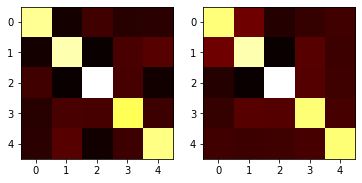

In [8]:
query = key = value = inputs_embeds
dim_k = key.size(-1)
scores = torch.bmm(query, key.transpose(1,2)) / sqrt(dim_k) 
f, axarr = plt.subplots(1,2)
axarr[0].imshow(scores[0].detach(), cmap='hot', interpolation=None)
axarr[1].imshow(scores[1].detach(), cmap='hot', interpolation=None)


In [9]:
weights = nn.functional.softmax(scores, dim=-1)
weights.sum(dim=-1) 
attn_outputs = torch.bmm(weights, value) 
attn_outputs.shape

torch.Size([2, 5, 768])

In [31]:
def scaled_dot_product_attention(query, key, value, mask=None): 
    dim_k = query.size(-1) 
    scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float("-inf"))
    weights = nn.functional.softmax(scores, dim=-1)
    return torch.bmm(weights, value)


In [32]:
class AttentionHead(nn.Module): 
    def __init__(self, embed_dim, head_dim): 
        super().__init__() 
        self.q = nn.Linear(embed_dim, head_dim) 
        self.k = nn.Linear(embed_dim, head_dim) 
        self.v = nn.Linear(embed_dim, head_dim) 
    def forward(self, hidden_state): 
        attn_outputs = scaled_dot_product_attention( self.q(hidden_state), self.k(hidden_state), self.v(hidden_state)) 
        return attn_outputs

In [33]:
class MultiHeadAttention(nn.Module): 
    def __init__(self, config): 
        super().__init__() 
        embed_dim = config.hidden_size 
        num_heads = config.num_attention_heads 
        head_dim = embed_dim // num_heads 
        self.heads = nn.ModuleList( [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)] ) 
        self.output_linear = nn.Linear(embed_dim, embed_dim) 
    def forward(self, hidden_state): 
        x = torch.cat([head.forward(hidden_state) for head in self.heads], dim=-1) 
        x = self.output_linear(x)
        return x

In [34]:
multihead_attn = MultiHeadAttention(config)
attn_output = multihead_attn(inputs_embeds)
attn_output.size()

torch.Size([2, 5, 768])

In [35]:
class FeedForward(nn.Module): 
    def __init__(self, config): 
        super().__init__() 
        self.linear_1 = nn.Linear(config.hidden_size, config.intermediate_size) 
        self.linear_2 = nn.Linear(config.intermediate_size, config.hidden_size) 
        self.gelu = nn.GELU() 
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
    def forward(self, x): 
        x = self.linear_1(x) 
        x = self.gelu(x) 
        x = self.linear_2(x) 
        x = self.dropout(x) 
        return x


In [36]:
feed_forward = FeedForward(config) 
ff_outputs = feed_forward(attn_outputs) 
ff_outputs.size() 

torch.Size([2, 5, 768])

In [37]:
class TransformerEncoderLayer(nn.Module): 
    def __init__(self, config): 
        super().__init__() 
        self.layer_norm_1 = nn.LayerNorm(config.hidden_size) 
        self.layer_norm_2 = nn.LayerNorm(config.hidden_size) 
        self.attention = MultiHeadAttention(config) 
        self.feed_forward = FeedForward(config) 
    def forward(self, x): 
        # Apply layer normalization and then copy input into query, key, valu
        hidden_state = self.layer_norm_1(x) 
        # Apply attention with a skip connection 
        x = x + self.attention(hidden_state) 
        # Apply feed-forward layer with a skip connection 
        x = x + self.feed_forward(self.layer_norm_2(x)) 
        return x


In [38]:
encoder_layer = TransformerEncoderLayer(config) 
inputs_embeds.shape, encoder_layer(inputs_embeds).size() 

(torch.Size([2, 5, 768]), torch.Size([2, 5, 768]))

In [39]:
class Embeddings(nn.Module): 
    def __init__(self, config): 
        super().__init__() 
        self.token_embeddings = nn.Embedding(config.vocab_size, config.hidden_size) 
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size) 
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps=1e-12) 
        self.dropout = nn.Dropout() 
    def forward(self, input_ids): 
        # Create position IDs for input sequence 
        seq_length = input_ids.size(1) 
        position_ids = torch.arange(seq_length, dtype=torch.long).unsqueeze(0)
        # Create token and position embeddings 
        token_embeddings = self.token_embeddings(input_ids) 
        position_embeddings = self.position_embeddings(position_ids) 
        # Combine token and position embeddings 
        embeddings = token_embeddings + position_embeddings 
        embeddings = self.layer_norm(embeddings) 
        embeddings = self.dropout(embeddings) 
        return embeddings 

In [40]:
embedding_layer = Embeddings(config)
print(inputs.input_ids)
print('embedding size', embedding_layer(inputs.input_ids).size())


tensor([[ 2051, 10029,  2066,  2019,  8612],
        [ 5909, 10029,  2066,  1037, 15212]])
embedding size torch.Size([2, 5, 768])


In [41]:
class TransformerEncoder(nn.Module): 
    def __init__(self, config): 
        super().__init__() 
        self.embeddings = Embeddings(config) 
        self.layers = nn.ModuleList([TransformerEncoderLayer(config) for _ in range(config.num_hidden_layers)]) 
    def forward(self, x):
        x = self.embeddings(x) 
        for layer in self.layers: 
            x = layer(x)
        return x

In [42]:
encoder = TransformerEncoder(config) 
encoder(inputs.input_ids).size()

torch.Size([2, 5, 768])

In [43]:
class TransformerForSequenceClassification(nn.Module): 
    def __init__(self, config): 
        super().__init__() 
        self.encoder = TransformerEncoder(config) 
        self.dropout = nn.Dropout(config.hidden_dropout_prob) 
        self.classifier = nn.Linear(config.hidden_size, config.num_labels) 
    def forward(self, x): 
        x = self.encoder(x)[:, 0, :] 
        # select hidden state of [CLS] token 
        x = self.dropout(x) 
        x = self.classifier(x) 
        return x

In [44]:
config.num_labels = 3 
encoder_classifier = TransformerForSequenceClassification(config) 
encoder_classifier(inputs.input_ids) 


tensor([[-0.4573,  0.2507, -0.1407],
        [-0.9383, -0.2864,  1.8039]], grad_fn=<AddmmBackward0>)

In [47]:
seq_len = inputs.input_ids.size(-1) 
mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0) 
print(mask)
scores.masked_fill(mask == 0, float("-inf"))


tensor([[[1., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 0.],
         [1., 1., 1., 1., 1.]]])


tensor([[[26.2274,    -inf,    -inf,    -inf,    -inf],
         [-1.7756, 27.0742,    -inf,    -inf,    -inf],
         [ 0.3339, -2.3140, 29.5995,    -inf,    -inf],
         [-0.8729,  0.7903,  0.5948, 24.2072,    -inf],
         [-0.8145,  1.3911, -1.9025,  0.1320, 25.6777]],

        [[25.3454,    -inf,    -inf,    -inf,    -inf],
         [ 2.4803, 27.0742,    -inf,    -inf,    -inf],
         [-0.9619, -2.3140, 29.5995,    -inf,    -inf],
         [-0.2433,  1.3257,  1.2656, 25.1502,    -inf],
         [ 0.3662,  0.1117,  0.2483,  0.5816, 25.1300]]],
       grad_fn=<MaskedFillBackward0>)